In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [118]:
xmax = 5 #max x values in m
ymax = 5 #max y values in m
zmax = 5 #max z values in m
h = 1 #amount of space each point represents in m**3

In [119]:
space = np.zeros((xmax, ymax, zmax))

In [120]:
dens = space

In [121]:
moisture = space

In [122]:
pressure = space

In [123]:
temp = space

In [124]:
vel = space

# Wind

In [174]:
def sun_e(space, eavg='1.08e7', edist=np.random.normal(), estd=1):
    '''
    :Arguments:
        *space*
            numpy.array 3-D array of zeros
        *eavg*
            int average value of energy from sun in J/m**2/day;
            default = 1.08e7 (average over Chicago)
        *edist*
            func distribution type for e sampling
        *estd*
            int standard deviation of energy from sun from eavg;
            default = 1
    :Returns:
        *energies*
            numpy.array values of energy from sun in J/m**2/day using
            edist with mean eavg
    '''
    for i in range(np.array(space.shape)[0]):
        for j in range(np.array(space.shape)[1]):
            e = edist(loc=eavg, scale=estd)
            energies[i, j, -1] = e

    return energies

# Cloud

In [175]:
def cloud(space, loc=(10,10,10), size=(10,1,1), hcloud=1, hmed=.95, hair=.69):
    '''
    :Arguments:
        *space*
            numpy.array 3-D array of zeros
        *loc*
            tuple location of center of cloud;
            default = (10,10,10)
        *size*
            tuple size of cloud;
            default = (10,1,1)
        *hcloud*
            int humidity of cloud;
            default = 1
        *hair*
            int humidity of air;
            default = 0
    :Returns:
        *humidities*
            numpy.array values of humidity
    '''
    assert all([i >= 0 for i in np.array(loc)-np.array(size)/2]) and \
    all([i >= 0 for i in np.array(space.shape)-np.array(loc)+np.array(size)/2]), \
    'Cloud must be within space.'

    humidities = space

    humidities[:][:][:] = hair

    n = np.array(size) % 2

    i = np.array(loc)[0]
    j = np.array(loc)[1]
    k = np.array(loc)[2]

    a0 = int(i-np.array(size)[0]/2)
    a1 = int(i+np.array(size)[0]/2) + n[0]
    b0 = int(j-np.array(size)[1]/2)
    b1 = int(j+np.array(size)[1]/2) + n[1]
    c0 = int(k-np.array(size)[2]/2)
    c1 = int(k+np.array(size)[2]/2) + n[2]

    humidities[a0-1:a1+1, b0-1:b1+1, c0-1:c1+1] = hmed
    humidities[a0:a1, b0:b1, c0:c1] = hcloud

    return humidities

In [176]:
humidities = cloud(space)

AssertionError: Cloud must be within space.

In [177]:
humidities

array([[[ 101325.        ,  101325.        ,  101325.        , ...,
          101325.        ,  101325.        ,  101325.        ],
        [ 101325.        ,  101325.        ,  101325.        , ...,
          101325.        ,  101325.        ,  101325.        ],
        [ 101325.        ,  101325.        ,  101325.        , ...,
          101325.        ,  101325.        ,  101325.        ],
        ..., 
        [ 101325.        ,  101325.        ,  101325.        , ...,
          101325.        ,  101325.        ,  101325.        ],
        [ 101325.        ,  101325.        ,  101325.        , ...,
          101325.        ,  101325.        ,  101325.        ],
        [ 101325.        ,  101325.        ,  101325.        , ...,
          101325.        ,  101325.        ,  101325.        ]],

       [[ 101312.8613842 ,  101312.8613842 ,  101312.8613842 , ...,
          101312.8613842 ,  101312.8613842 ,  101312.8613842 ],
        [ 101312.8613842 ,  101312.8613842 ,  101312.8613842

# Tornado

In [178]:
def tornado(space, loc=10, lpress=10, rpress=1):
    '''
    :Arguments:
        *space*
            numpy.array 3-D array of zeros
        *loc*
            int location of pressure difference;
            default = 10

    :Returns:
        *pressures*
            numpy.array values of pressure
    '''
    assert 0 < loc and loc < np.array(space.shape)[0], 'Pressure difference must be within space.'

    pressures = altitude_pressures(space)

    pressures[loc:, :, :] *= rpress

    pressures[:loc, :, :] *= lpress

    return pressures

In [179]:
tornado(space)

AssertionError: Pressure difference must be within space.

# Algorithm

In [180]:
def energytopressure(energies, dv):
    ps = energies/dV
    return ps

In [181]:
def altitude_pressures(space):
    pressures = space
    for h in range(np.array(space.shape)[2]):
        p = 101325*np.e**(-0.000119806*h)
        pressures[:, :, h] = p
    return pressures

In [182]:
def calc_pchange(pressures, dt, T=329,M1=29,M2=29):
    A = 1.858e-3
    Dcm = A*T**(3/2)*np.sqrt((1/M1+1/M2))/(pressures*(1/2*(s1+s2))**2*omega)
    D = Dcm / 100**2
    R = 8.314598
    for i in range(np.array(pressures.shape)[0]):
        for j in range(np.array(pressures.shape)[1]):
            for k in range(np.array(pressures.shape)[2]):
                p = pressures[i, j, k]
                try:
                    assert i-1 != -1
                    pleft = pressures[i-1, j, k]
                    n = pleft*dV/(R*T)
                    phileft = n/dV
                except:
                    phileft = np.nan

                try:
                    pright = pressures[i+1, j, k]
                    n = pright*dv/(R*T)
                    phiright = n/dv
                except:
                    phiright = np.nan
                    
                try:
                    assert j-1 != -1
                    pfront = pressures[i, j-1, k]
                    n = pfront*dV/(R*T)
                    phifront = n/dV
                except:
                    phifront = np.nan
                try:
                    pback = pressures[i, j+1, k]
                    n = pback*dV/(R*T)
                    phiback = n/dV
                except:
                    phiback = np.nan
                try:
                    assert k-1 != -1
                    pdown = pressures[i, j, k-1]
                    n = pdown*dV/(R*T)
                    phidown = n/dV
                except:
                    phidown = np.nan
                try:
                    pup = pressures[i, j, k+1]
                    n = pup*dV/(R*T)
                    phiup = n/dV
                except:
                    phiup = np.nan
                    
                n = p*dV/(R*T)
                phi = n/dV
                J = -D*gradphi

                gradphix = 
                gradphiy = 
                gradphiz = 

SyntaxError: invalid syntax (<ipython-input-182-db842df3cb8d>, line 9)

In [ ]:
def water_diffusion(moisture, dt)
    Dcm = .282
    D = Dcm /100**2

In [172]:
def integrate_from_sun(space, pressures, velocities, dV=1, tmax=20,
                       dt=1):
    times = np.arange(0, tmax, dt)
    pt = np.array(times, np.array(space)[0],
                  np.array(space)[1], np.array(space)[2])
    ps = altitude_pressures(space)
    for t in times:
        pt[t] = ps
        energies = sun_e(space)
        ps += energytopressure(energies, dV)
        ps = calc_pchange(ps, dt)
    return pt

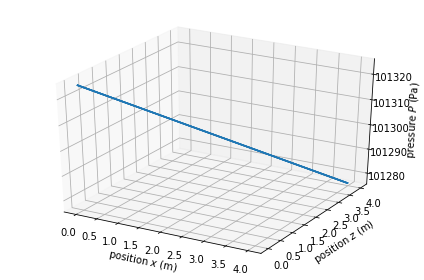

In [160]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_wireframe(np.arange(np.array(ps.shape)[0]), np.arange(np.array(ps.shape)[2]), ps[:,0,:])
ax.set_xlabel(r"position $x$ (m)")
ax.set_ylabel(r"position $z$ (m)")
ax.set_zlabel(r"pressure $P$ (Pa)")
fig.tight_layout()